In [469]:
import qiskit_aer.noise as noise
from qiskit.providers.aer.noise import NoiseModel
from qiskit import QuantumCircuit, Aer, execute
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error
import qiskit.providers.fake_provider as fake_provider # FakeMelbourneV2, FakeCasablancaV2, FakeVigoV2, FakeLagosV2, FakeGuadalupeV2, FakeGuadalupe, FakeGeneva
# Zugriff auf die Variablen
backend = fake_provider.FakeVigoV2()

noise_model = NoiseModel.from_backend(backend)
#print(noise_model)
#print(noise_model.noise_instructions)
#print(noise_model._default_quantum_errors)
#print(noise_model._local_quantum_errors)
for key in noise_model._local_quantum_errors:
    #print(key)
    pass
#for key in noise_model._local_quantum_errors:
key = 'x'
for key2 in noise_model._local_quantum_errors[key]:
    #print(key, key2, noise_model._local_quantum_errors[key][key2])
    pass
    #print(key, noise_model._local_quantum_errors[key][(0,)])
    pass
    #print("test")

In [470]:
import random
for i in range(100000):
    if random.random() < 1/100000:
        print("Hello")

In [471]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.providers.fake_provider import FakeMelbourneV2, FakeVigoV2
from matplotlib import pyplot as plt
import os
import sys
import numpy as np

sys.path.append("pauli_lindblad_per")

from tomography.experiment import SparsePauliTomographyExperiment as tomography
from primitives.pauli import QiskitPauli

plt.style.use("ggplot")

backend = FakeVigoV2()

# %%
qubits= [0,1,2,3]
print("make trotter")
def trotterLayer(h,J,dt,n):
    trotterLayer = QuantumCircuit(4)
    trotterLayer.rx(dt*4*h, qubits)
    trotterLayer.cx(*zip(*[(qubits[2*i], qubits[2*i+1]) for i in range(n)]))
    trotterLayer.rz(-4*J*dt, [qubits[2*i+1] for i in range(n)])
    trotterLayer.cx(*zip(*[(qubits[2*i], qubits[2*i+1]) for i in range(n)]))
    trotterLayer.cx(*zip(*[(qubits[2*i+1], qubits[2*i+2]) for i in range(n-1)]))
    trotterLayer.rz(-4*J*dt, [qubits[2*i+2] for i in range(n-1)])
    trotterLayer.cx(*zip(*[(qubits[2*i+1], qubits[2*i+2]) for i in range(n-1)]))
    return trotterLayer

h = 1
J = -.15
dt = .2
n = 2

def maketrotterCircuit(s):
    tL = trotterLayer(h, J, dt, n)
    trotterCircuit = QuantumCircuit(4)
    for i in range(s):
        trotterCircuit = trotterCircuit.compose(tL)
        trotterCircuit.barrier()

    #transpiled = transpile(trotterCircuit, backend)
    return tL

circuits = [maketrotterCircuit(i) for i in range(1,2)]
used_qubits = set()
for circuit in circuits: 
    for c in circuit: #look at the commands
        for bit in c.qubits: #record which qubits they use
            used_qubits.add(bit.index) #and save those
qubits = used_qubits
print("Qubits set to ", qubits)
circuits[0].draw()

make trotter
Qubits set to  {0, 1, 2, 3}


C:\Users\fabri\AppData\Local\Temp\ipykernel_4240\1203451751.py:51: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  used_qubits.add(bit.index) #and save those


┌─────────┐                                            
q_0: ┤ Rx(0.8) ├──■────────────────■────────────────────────
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐                      
q_1: ┤ Rx(0.8) ├┤ X ├┤ Rz(0.12) ├┤ X ├──■────────────────■──
     ├─────────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
q_2: ┤ Rx(0.8) ├──■────────────────■──┤ X ├┤ Rz(0.12) ├┤ X ├
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
q_3: ┤ Rx(0.8) ├┤ X ├┤ Rz(0.12) ├┤ X ├──────────────────────
     └─────────┘└───┘└──────────┘└───┘

In [472]:
from primitives.circuit import QiskitCircuit
def circuit_to_layers(qc: QiskitCircuit):
    layers = []
    inst_list = [inst for inst in qc if not inst.ismeas()] 

    #pop off instructions until inst_list is empty
    while inst_list:

        circ = qc.copy_empty() #blank circuit to add instructions
        layer_qubits = set() #qubits in the support of two-qubit clifford gates

        for inst in inst_list.copy(): #iterate through remaining instructions

            #check if current instruction overlaps with support of two-qubit gates
            #already on layer
            if not layer_qubits.intersection(inst.support()):
                circ.add_instruction(inst) #add instruction to circuit and pop from list
                inst_list.remove(inst)

            if inst.weight() == 2:
                layer_qubits = layer_qubits.union(inst.support()) #add support to layer

        if circ: #append only if not empty
            layers.append(circ)

    return layers

cross_talk_chance = 0.00001
def apply_cross_talk(circuit, new_circuits):
    import random

    if backend.num_qubits != len(circuit.qubits):
        circuit = transpile(circuit, backend)

    #rebuild the circuit
    circ = circuit.copy_empty_like()
    # Cut into layer, so you know all 2 qubit gates in one layer are parallel
    layers = circuit_to_layers(QiskitCircuit(circuit))
    for layer in layers:
        # Count up which qubit has the most instructions on it. Assume all instructions take the same time to resolve
        qubits = []
        for inst in layer:
            if inst.weight() == 1:
                qubits.append(inst.instruction.qubits)
        # Save which qubit is the most gated and also how many gates it has
        most_gate_qubit = -1
        most_gate_qubit_count = -1
        for qubit in set(qubits):
            if qubits.count(qubit) > most_gate_qubit_count:
                most_gate_qubit_count = qubits.count(qubit)
                most_gate_qubit = qubit
        # rebuild the circuit
        for inst in layer:
            inst = inst.instruction
            circ.append(inst)
            # At every single qubit layer, determined by the most gated qubit, apply a random cnot gate, with chance=cross_talk_chance
            if inst.qubits == most_gate_qubit:
                for edge in backend.coupling_map: # Every edge has a chance to send noise
                    if random.random() < cross_talk_chance: # And every qubit does that individual from one another
                        circ.cx(edge[0], edge[1])
                    if random.random() < cross_talk_chance: # Order could play a role, but the chance is to low,
                        circ.cx(edge[1], edge[0]) # that both hit at the same time, that it is ignored here
                        # Another thing to add is: Bydefault, these cnot gates are also noisy themself
                        # I consider this an upside, as cross talk noise is also not always the same.
        # Multiqubit gates take a longer time to resolve, on average 3 times longer.
        # This means, that there are 3 times more chances for a cross talk noise to occure
        for edge in backend.coupling_map: 
            if random.random() < 3*cross_talk_chance: 
                circ.cx(edge[0], edge[1])
            if random.random() < 3*cross_talk_chance: 
                circ.cx(edge[1], edge[0])
    new_circuits.append(circ)

In [473]:
liste = []
qc = circuits[0]
qc2 = transpile(qc, backend)
qc2.draw()


»
ancilla_0 -> 0 ────────────────────────────────────────────────────────────────»
               ┌─────────┐┌────┐┌──────────────────────┐┌────┐┌──────────┐┌───┐»
      q_1 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.94159265358979) ├┤ √X ├┤ Rz(5π/2) ├┤ X ├»
               ├─────────┤├────┤├──────────────────────┤├────┤├──────────┤└─┬─┘»
      q_0 -> 2 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.94159265358979) ├┤ √X ├┤ Rz(5π/2) ├──■──»
               ├─────────┤├────┤├──────────────────────┤├────┤├──────────┤     »
      q_2 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.94159265358979) ├┤ √X ├┤ Rz(5π/2) ├──■──»
               ├─────────┤├────┤├──────────────────────┤├────┤├──────────┤┌─┴─┐»
      q_3 -> 4 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.94159265358979) ├┤ √X ├┤ Rz(5π/2) ├┤ X ├»
               └─────────┘└────┘└──────────────────────┘└────┘└──────────┘└───┘»
«                                                      
«ancilla_0 -> 0 ───────────────────────────────────────
«               ┌──────────┐┌───┐                      
«      q_1 -> 1 ┤ Rz(0.12) ├┤ X ├──■────────────────■──
«               └──────────┘└─┬─┘  │                │  
«      q_0 -> 2 ──────────────■────┼────────────────┼──
«                                ┌─┴─┐┌──────────┐┌─┴─┐
«      q_2 -> 3 ──────────────■──┤ X ├┤ Rz(0.12) ├┤ X ├
«               ┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
«      q_3 -> 4 ┤ Rz(0.12) ├┤ X ├──────────────────────
«               └──────────┘└───┘

In [474]:
apply_cross_talk(qc, liste)
liste[0].draw()


»
ancilla_0 -> 0 ────────────────────────────────────────────────────────────────»
               ┌─────────┐┌────┐┌──────────────────────┐┌────┐┌──────────┐┌───┐»
      q_1 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.94159265358979) ├┤ √X ├┤ Rz(5π/2) ├┤ X ├»
               ├─────────┤├────┤├──────────────────────┤├────┤├──────────┤└─┬─┘»
      q_0 -> 2 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.94159265358979) ├┤ √X ├┤ Rz(5π/2) ├──■──»
               ├─────────┤├────┤├──────────────────────┤├────┤├──────────┤     »
      q_2 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.94159265358979) ├┤ √X ├┤ Rz(5π/2) ├──■──»
               ├─────────┤├────┤├──────────────────────┤├────┤├──────────┤┌─┴─┐»
      q_3 -> 4 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.94159265358979) ├┤ √X ├┤ Rz(5π/2) ├┤ X ├»
               └─────────┘└────┘└──────────────────────┘└────┘└──────────┘└───┘»
«                                                      
«ancilla_0 -> 0 ───────────────────────────────────────
«               ┌──────────┐┌───┐                      
«      q_1 -> 1 ┤ Rz(0.12) ├┤ X ├──■────────────────■──
«               └──────────┘└─┬─┘  │                │  
«      q_0 -> 2 ──────────────■────┼────────────────┼──
«                                ┌─┴─┐┌──────────┐┌─┴─┐
«      q_2 -> 3 ──────────────■──┤ X ├┤ Rz(0.12) ├┤ X ├
«               ┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
«      q_3 -> 4 ┤ Rz(0.12) ├┤ X ├──────────────────────
«               └──────────┘└───┘

: 

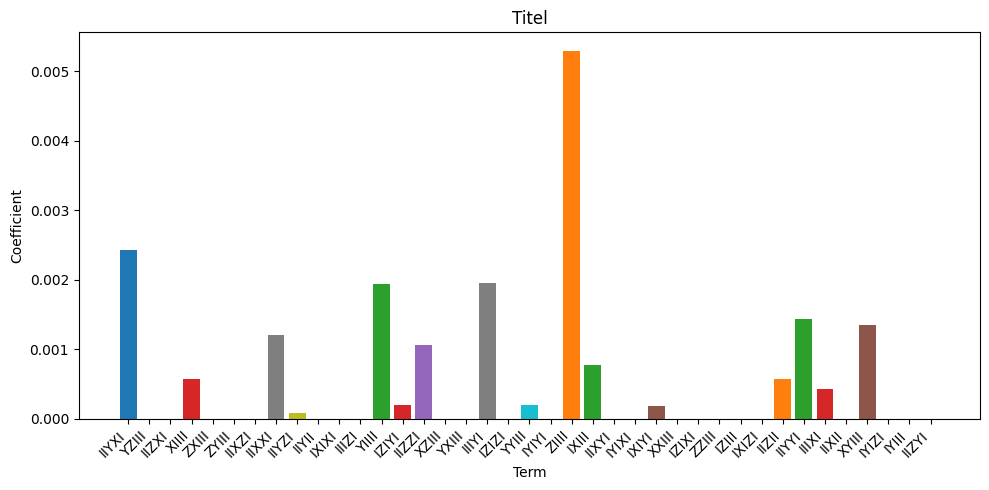

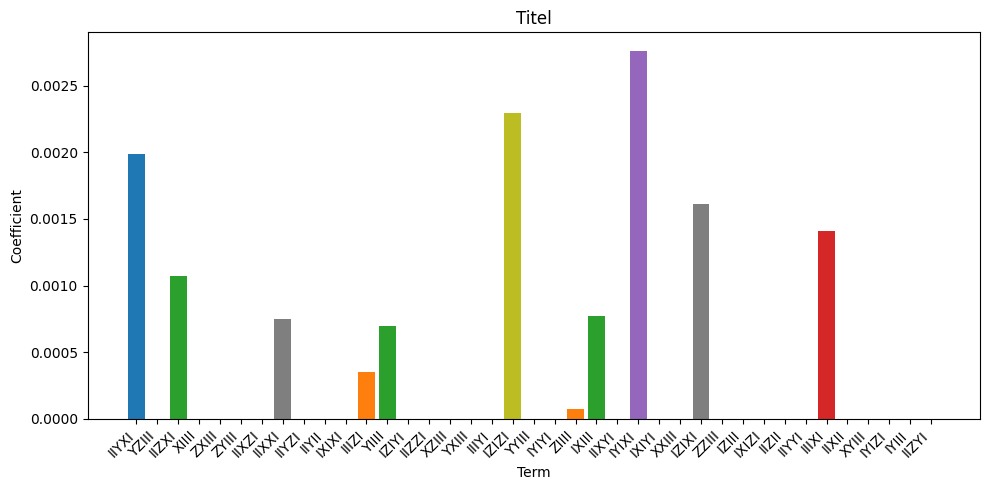

: 

In [11]:
import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit, Aer, transpile
from matplotlib import pyplot as plt
import os
import sys
import numpy as np
import json
import time

folder = os.getcwd()
while not folder.endswith("AutomatedPERTools"):
    folder = os.path.dirname(folder)
sys.path.append(os.path.join(folder, "pauli_lindblad_per"))

from tomography.experiment import SparsePauliTomographyExperiment as tomography
from primitives.pauli import QiskitPauli



import pickle

with open("noisedataframe.pickle", "rb") as f:
    noisedataframe = pickle.load(f)
for key in noisedataframe.noisemodels:
    #print(key, noisedataframe.noisemodels[key].coeffs)
    data = noisedataframe.noisemodels[key].coeffs
    # Create the bar plot
    plt.figure(figsize=(10, 5))  # Adjust the figure size if needed
    for tup in data:
        plt.bar(str(tup[0]),float(tup[1]))

    # Add labels and title
    plt.xlabel("Term")
    plt.ylabel("Coefficient")
    plt.title('Titel')

    # Rotate names if too long for better readability
    plt.xticks(rotation=45, ha='right')

    # Display the plot
    plt.tight_layout()
    plt.show()


In [ ]:
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error
from qiskit import QuantumCircuit, Aer, execute

# Create a custom noise model
noise_model = NoiseModel()

# Create a quantum circuit
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

# Simulate the circuit with the noise model
simulator = Aer.get_backend('qasm_simulator')
meta_result = {}
result = execute(qc, simulator, noise_model=noise_model).result()
result2 = execute(qc, simulator, noise_model=noise_model).result()

print(result.get_counts())
print(result2.get_counts())
for res in [result, result2]:
    for key in res.get_counts():
        if key in meta_result:
            meta_result[key] += res.get_counts()[key]
        else:
            meta_result[key] = res.get_counts()[key]
# Print the results
print(meta_result)